In [6]:
import pandas as pd
from Training.utlis import train_test_split_data
from sklearn.pipeline import Pipeline
import ClassicalApproach as ca
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import joblib

### Data Loading

In [2]:
df = pd.read_pickle("../data/combined_df.pkl")
df["content_text_joined"] = df["content_words"].apply(lambda x: " ".join(x))


TEXT_COL = "content_text_joined"    
LABEL_COL = "is_spoiler"      

# Split
X_train, _, y_train, _ = train_test_split_data(
    df,
    TEXT_COL,
    LABEL_COL
)

In [37]:
def optimize_model_parameters(X, y, param_1, param_1_range, param_2, param_2_range,method,clf,k_folds=5):
    model_params={}
    loss_matrix=np.zeros((len(param_1_range),len(param_2_range)))
    for i,param_1_value in enumerate(param_1_range):
        model_params[param_1]=param_1_value
        for j,param_2_value in enumerate(param_2_range):
            model_params[param_2]=param_2_value
            losses=np.zeros(k_folds)
            cv=KFold(n_splits=k_folds, shuffle=True,random_state=(i*len(param_1_range)+j))
            for k,(train_index, test_index) in enumerate(cv.split(X)):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                ppln=Pipeline(steps=[
                    ('vec',ca.get_vectorizer(method=method,
                    **model_params
                    )),
                    ('clf',ca.get_model(clf))
                ])
                ppln.fit(X_train, y_train)
                y_pred=ppln.predict(X_test)
                loss=f1_score(y_test, y_pred)
                losses[k]=loss
            loss_matrix[i,j]=np.mean(losses)
        print(f"{i}-th outer loop finished")
    return loss_matrix
            
def plot_heatmap(loss_matrix, param_1, param_1_range, param_2, param_2_range,method,clf):
   
    x_indices = np.arange(len(param_1_range))
    y_indices = np.arange(len(param_2_range))
    x, y = np.meshgrid(x_indices, y_indices)
    loss_min, loss_max = loss_matrix.min(), loss_matrix.max()
    plt.figure(figsize=(10,10))
    plt.pcolormesh(x, y, loss_matrix.T, vmin=loss_min, vmax=loss_max, cmap='RdBu', shading='nearest')
    plt.xlabel(param_1)
    plt.ylabel(param_2)
    plt.colorbar(label='F1 Score')
    plt.title(f"F1 score for parameters {param_1}/{param_2}")
    plt.savefig(f"figs/hyperparams{method}_{clf}.png")
    plt.show()
    
    idx = np.unravel_index(np.argmax(loss_matrix, axis=None), loss_matrix.shape)
    best_p1 = param_1_range[idx[0]]
    best_p2 = param_2_range[idx[1]]
    print(f"Best Score: {loss_max:.4f}")
    print(f"Best {param_1}: {best_p1}, Best {param_2}: {best_p2}")
    

In [19]:
max_features_vals=[5000,7500,10000,12500,15000]
ngram_range_vals=[(1,2),(1,3),(1,4),(2,3)]

### Training Tfidf + SVM model

In [34]:
len(ngram_range_vals)

4

In [ ]:
score_matrix=optimize_model_parameters(X_train.to_numpy(),y_train.to_numpy(),"max_features",max_features_vals,'ngram_range',ngram_range_vals,'tfidf','svm')


In [21]:
score_matrix

array([[0.65426403, 0.6547654 , 0.65468136, 0.59523102],
       [0.64800312, 0.6460942 , 0.64960535, 0.5901942 ],
       [0.64389767, 0.64481037, 0.64315138, 0.58707413],
       [0.6377826 , 0.63976064, 0.64122451, 0.58795419],
       [0.63803114, 0.63757313, 0.6401066 , 0.58011982]])

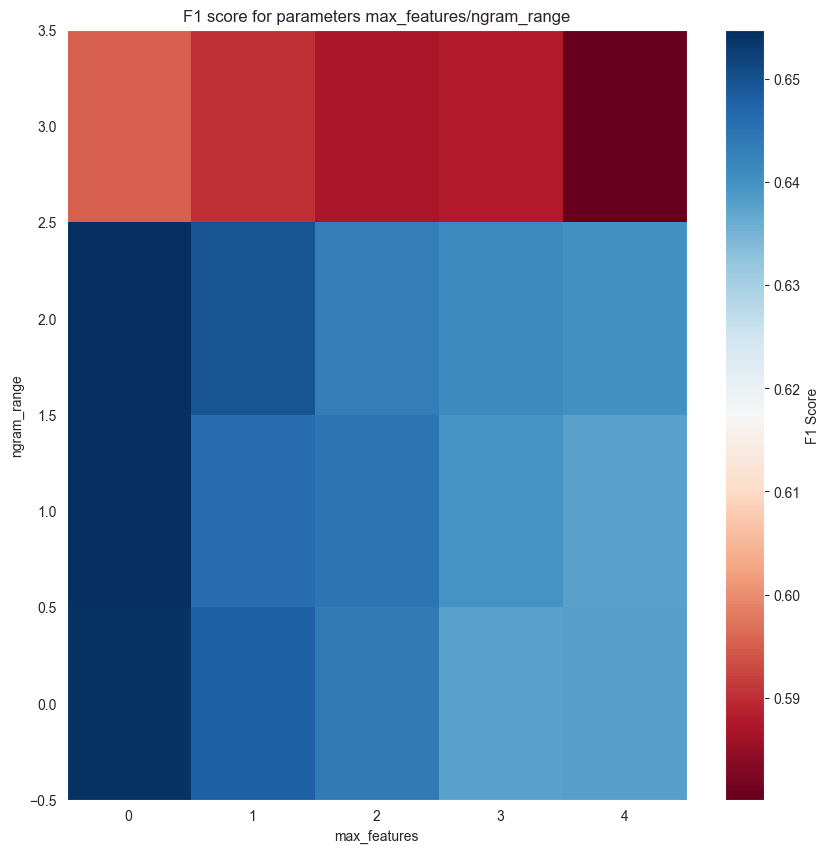

Best Score: 0.6548
Best max_features: 5000, Best ngram_range: (1, 3)


In [38]:
plot_heatmap(score_matrix,"max_features",max_features_vals,'ngram_range',ngram_range_vals,'tfidf','svm')

In [39]:
tfidf_svm_pipeline = Pipeline(steps=[
    ('vec',ca.get_vectorizer(method="tfidf",
    max_features=5000,
    ngram_range=(1, 3))),
    ('clf',ca.get_model("svm"))
])
tfidf_svm_pipeline.fit(X_train,y_train)
print("pipeline training completed")


pipeline training completed


### Bow + Logistic Regression Training

In [42]:
score_matrix=optimize_model_parameters(X_train.to_numpy(),y_train.to_numpy(),"max_features",max_features_vals,'ngram_range',ngram_range_vals,'bow','logreg')

0-th outer loop finished
1-th outer loop finished
2-th outer loop finished
3-th outer loop finished
4-th outer loop finished


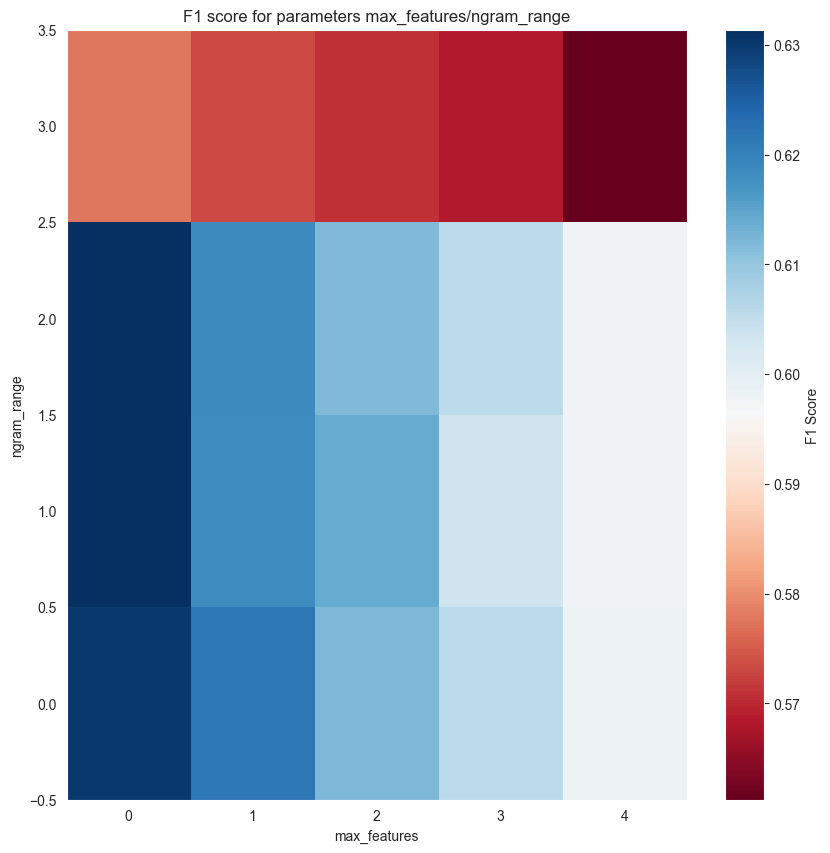

Best Score: 0.6314
Best max_features: 5000, Best ngram_range: (1, 3)


In [43]:
plot_heatmap(score_matrix,"max_features",max_features_vals,'ngram_range',ngram_range_vals,'bow','logreg')

In [44]:
bow_logreg_pipeline = Pipeline(steps=[
    ('vec',ca.get_vectorizer(method="bow",
    max_features=5000,
    ngram_range=(1, 3))),
    ('clf',ca.get_model('logreg'))
])
bow_logreg_pipeline.fit(X_train,y_train)
print("pipeline training completed")


pipeline training completed


### Saving models

array([ True,  True, False, ...,  True, False, False], shape=(70000,))

In [45]:
joblib.dump(bow_logreg_pipeline, "../Models/logreg_bow.pkl")


['../Models/logreg_bow.pkl']

In [41]:
joblib.dump(tfidf_svm_pipeline, "../Models/svm_tfidf.pkl")

['../Models/svm_tfidf.pkl']